> Copyright 2022 Bruno César Brito Sant'Anna <mail@bsantanna.me>
>
> Licensed under the Apache License, Version 2.0 (the "License");
> you may not use this file except in compliance with the License.
> You may obtain a copy of the License at
>
>     http://www.apache.org/licenses/LICENSE-2.0
>
> Unless required by applicable law or agreed to in writing, software
> distributed under the License is distributed on an "AS IS" BASIS,
> WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
> See the License for the specific language governing permissions and
> limitations under the License.

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

In [2]:
# Globals
batch_size = 32
num_epochs = 500

# Structured tabular iban data
# Original Source: https://github.com/open-ibans/ibans-python
iban_data = pd.read_csv("../../ibans.txt", sep="|")

In [3]:
# Utility functions
# Original Source: https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

def build_model(dataset):
    # for x, y in train_dataset.take(1):
    #     print("Input:", x)
    #     print("Target:", y)

    # Categorical feature encoded as string
    feature_prefix = tf.keras.Input(shape=(1,), name="Prefix", dtype="string")
    feature_prefix_encoded = encode_categorical_feature(feature_prefix, "Prefix", dataset, is_string=True, use_lookup=True)

    # Numerical feature
    feature_size = tf.keras.Input(shape=(1,), name="Size", dtype="int64")
    feature_size_encoded = encode_numerical_feature(feature_size, "Size", dataset)

    # Inputs
    inputs = [
        feature_prefix,
        feature_size
    ]

    features = tf.keras.layers.concatenate([
        feature_prefix_encoded,
        feature_size_encoded
    ])

    input_layer = tf.keras.layers.Dense(batch_size, activation="relu")(features)
    output_layer = tf.keras.layers.Dense(len(iban_data), activation="softmax")(input_layer)

    model = tf.keras.Model(inputs, output_layer)
    model.compile("adam", "categorical_crossentropy", metrics=[
        "accuracy",
    ])

    return model

def dataframe_to_dataset(dataframe):
    df = dataframe.drop("Country", axis=1)
    labels = tf.keras.utils.to_categorical(dataframe["Country"].factorize()[0])
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    return ds


def encode_numerical_feature(feature, name, dataset):
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    normalizer = tf.keras.layers.Normalization()
    normalizer.adapt(feature_ds)
    encoded_feature = normalizer(feature)

    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string=False, use_lookup=True, max_tokens=0):
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # for x, y in feature_ds.take(1):
    #     print("Input:", x)
    #     print("Target:", y)

    if use_lookup:
        encoding_layer_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
        encoding_layer = encoding_layer_class(output_mode="binary")
        encoding_layer.adapt(feature_ds)

    elif is_string:
        encoding_layer = tf.keras.layers.TextVectorization()
        encoding_layer.adapt(feature_ds)

    else:
        encoding_layer = tf.keras.layers.CategoryEncoding(num_tokens=max_tokens, output_mode="one_hot")

    encoded_feature = encoding_layer(feature)
    return encoded_feature


def predict_country(trained_model, prefix, size):
    prediction = trained_model.predict({
        "Prefix": tf.convert_to_tensor([prefix]),
        "Size": tf.convert_to_tensor([size])
    })
    # return max probability
    return iban_data["Country"][prediction.argmax()]

In [4]:
# Format tabular data
iban_data["Prefix"] = iban_data["Alpha"]
iban_data = iban_data.drop(["Alpha", "BBAN Format", "IBAN Fields"], axis=1)

iban_data.shape

(105, 3)

In [5]:
iban_data.isna().sum()

Country    0
Size       0
Prefix     0
dtype: int64

In [6]:
# initialize dataset
train_dataset = dataframe_to_dataset(iban_data).batch(batch_size)
train_model = build_model(train_dataset)

In [7]:
#tf.keras.utils.plot_model(train_model, show_shapes=True, rankdir="LR")

In [8]:
training_history = train_model.fit(train_dataset, epochs=num_epochs, verbose=0)

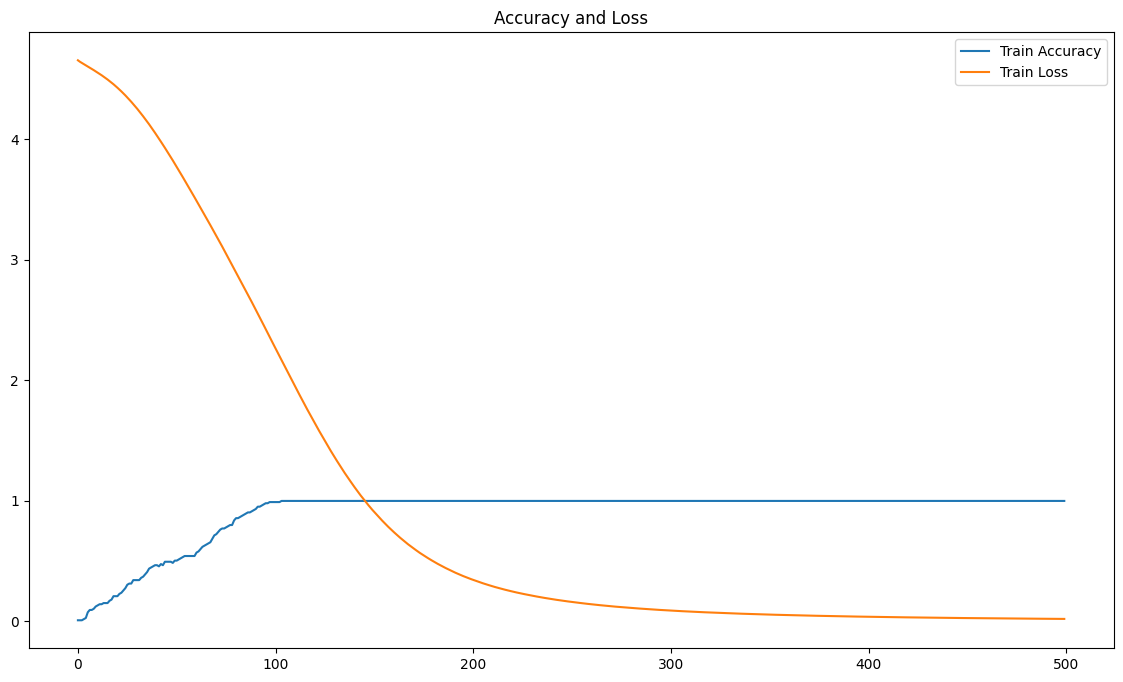

In [9]:
train_acc = training_history.history["accuracy"]
train_loss = training_history.history["loss"]

epochs_range = range(num_epochs)

plt.figure(figsize=(14, 8))

plt.plot(epochs_range, train_acc, label="Train Accuracy")
plt.plot(epochs_range, train_loss, label="Train Loss")
plt.title("Accuracy and Loss")
plt.legend()


In [10]:
train_model.save("bin")

INFO:tensorflow:Assets written to: bin/assets


INFO:tensorflow:Assets written to: bin/assets


In [11]:
restored_model = tf.keras.models.load_model("bin")

In [12]:
restored_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Prefix (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Size (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 106)          0           ['Prefix[0][0]']                 
                                                                                                  
 normalization (Normalization)  (None, 1)            3           ['Size[0][0]']                   
                                                                                              

In [13]:
iban_data.sample(3)

,Country,Size,Prefix
65,Morocco,28,MA
24,Germany,22,DE
81,Poland,28,PL


In [16]:
print("Country: {}".format(predict_country(restored_model, prefix="DE", size=22)))

1/1 [==============================] - 0s 48ms/step
Country: Germany
